In [1]:
# autoreload 
%load_ext autoreload
%autoreload 2
import argparse
import json
import os
import warnings
import sys

sys.path.append("../")

import pandas as pd
from sklearn.metrics import r2_score

from domains.samplers import SyntheticDataSampler
from models.MoE import MoE, MoELinear
from models.MoE import *
from models.utils import *
from models.additive_parallel_comp_model import get_additive_model_effects
warnings.filterwarnings('ignore')

def parse_arguments():
    parser = argparse.ArgumentParser(description="Train modular neural network architectures and baselines for causal effect estimation")
    parser.add_argument("--domain", type=str, default="synthetic_data", help="Domain")
    parser.add_argument("--biasing_covariate", type=str, default="feature_sum", help="Biasing covariate")
    parser.add_argument("--bias_strength", type=float, default=0, help="Bias strength")
    parser.add_argument("--scale", type=bool, default=False, help="Scale data")
    parser.add_argument("--num_modules", type=int, default=6, help="Number of modules")
    parser.add_argument("--num_feature_dimensions", type=int, default=1, help="Number of feature dimensions")
    parser.add_argument("--num_samples", type=int, default=10000, help="Number of samples")
    parser.add_argument("--module_function_type", type=str, default="quadratic", help="Module function type")
    parser.add_argument("--composition_type", type=str, default="parallel", help="Composition type")
    parser.add_argument("--resample", type=bool, default=True, help="Resample data")
    parser.add_argument("--seed", type=int, default=42, help="Seed for reproducibility")
    parser.add_argument("--fixed_structure", type=bool, default=True, help="Fixed structure flag")
    parser.add_argument("--data_dist", type=str, default="normal", help="Data distribution")
    parser.add_argument("--heterogeneity", type=float, default=1.0, help="Heterogeneity")
    parser.add_argument("--split_type", type=str, default="iid", help="Split type")
    # hidden_dim
    parser.add_argument("--hidden_dim", type=int, default=64, help="Hidden dimension")
    # epochs
    parser.add_argument("--epochs", type=int, default=100, help="Number of epochs")
    # batch_size
    parser.add_argument("--batch_size", type=int, default=64, help="Batch size")
    # output_dim
    parser.add_argument("--output_dim", type=int, default=1, help="Output dimension")
    # covariates_shared
    parser.add_argument("--covariates_shared", type=bool, default=True, help="Covariates shared")
    # model_class
    parser.add_argument("--underlying_model_class", type=str, default="MLP", help="Model class")
    # run_env
    parser.add_argument("--run_env", type=str, default="local", help="Run environment")
    # use_subset_features
    parser.add_argument("--use_subset_features", type=bool, default=False, help="Use subset features")
    # generate trees systematically for creating OOD data
    parser.add_argument("--systematic", type=bool, default=False, help="Generate trees systematically")
    return parser.parse_args(args=[])

def setup_directories(args):
    base_dir = "/Users/ppruthi/research/compositional_models/compositional_models_cate/domains" if args.run_env == "local" else "/work/pi_jensen_umass_edu/ppruthi_umass_edu/compositional_models_cate/domains"
    main_dir = f"{base_dir}/{args.domain}"
    csv_path = f"{main_dir}/csvs/fixed_structure_{args.fixed_structure}_outcomes_{args.composition_type}_systematic_{args.systematic}"
    obs_data_path = f"{main_dir}/observational_data/fixed_structure_{args.fixed_structure}_outcomes_{args.composition_type}_systematic_{args.systematic}"
    scaler_path = f"{obs_data_path}/{args.biasing_covariate}_{args.bias_strength}/{args.split_type}/scalers"
    return main_dir, csv_path, obs_data_path, scaler_path

def simulate_and_prepare_data(args, sampler, csv_path, obs_data_path, scaler_path):
    if args.resample:
        sampler.simulate_data()
        sampler.create_observational_data(biasing_covariate=args.biasing_covariate, bias_strength=args.bias_strength)
        sampler.create_iid_ood_split(split_type=args.split_type)
        sampler.create_scalers(args.split_type, biasing_covariate=args.biasing_covariate, bias_strength=args.bias_strength)
    data = pd.read_csv(f"{csv_path}/{args.domain}_data_high_level_features.csv")
    df_sampled = pd.read_csv(f"{obs_data_path}/{args.biasing_covariate}_{args.bias_strength}/df_sampled.csv")
    if args.scale:
        data, df_sampled = scale_df(data, df_sampled, scaler_path, csv_path)
    
    
    return data, df_sampled

def load_train_test_data(csv_path, args, df_sampled):
    with open(f"{csv_path}/{args.split_type}/train_test_split_qids.json", "r") as f:
        train_test_qids = json.load(f)
    train_qids, test_qids = train_test_qids["train"], train_test_qids["test"]
    train_df = df_sampled[df_sampled["query_id"].isin(train_qids)]
    test_df = df_sampled[df_sampled["query_id"].isin(test_qids)]
    return train_df, test_df, train_qids, test_qids

def train_and_evaluate_model(model, train_df, test_df, covariates, treatment, outcome, epochs, batch_size, train_qids, test_qids):
    model, _, _ = train_model(model, train_df, covariates, treatment, outcome, epochs, batch_size)
    train_estimates = predict_model(model, train_df, covariates)
    test_estimates = predict_model(model, test_df, covariates)
    train_df.loc[:, "estimated_effect"] = train_estimates
    test_df.loc[:, "estimated_effect"] = test_estimates
    estimated_effects_train = get_estimated_effects(train_df, train_qids)
    estimated_effects_test = get_estimated_effects(test_df, test_qids)
    return estimated_effects_train, estimated_effects_test

def calculate_metrics(gt_effects, estimated_effects):
    pehe_score = pehe(gt_effects, estimated_effects)
    r2_score_val = r2_score(gt_effects, estimated_effects)
    return pehe_score, r2_score_val

def process_shared_covariates_row_wise(train_df, test_df, args):
    if args.covariates_shared:
        def process_row(row):
            # Find non-zero modules for this row
            num_modules = [col for col in row.index if col.startswith('num_module_')]
            non_zero_modules = [int(col.split('_')[-1]) for col in num_modules if row[col] != 0]
            first_module = non_zero_modules[0]
            first_module_features = [col for col in row.index if col.startswith(f'module_{first_module}_feature_')]
            if not non_zero_modules:
                raise ValueError(f"No non-zero modules found for row with query_id {row['query_id']}")
            
            # Create a new row with renamed features
            new_row = {}
            for feature in first_module_features:
                feature_id = int(feature.split('_')[-1])
                new_row[f'feature_{feature_id}'] = row[feature]
            
            # Add other necessary columns
            for col in ['query_id', 'treatment_id', 'query_output', 'tree_depth'] + num_modules:
                new_row[col] = row[col]
            
            return pd.Series(new_row)

        # don't include header row
        train_df_processed = train_df.apply(process_row, axis=1)
        test_df_processed = test_df.apply(process_row, axis=1)
        print(f"Train data shape: {train_df_processed.shape}")
        print(f"Test data shape: {test_df_processed.shape}")
        
        # Ensure consistent column ordering
        columns_order = ['query_id', 'treatment_id', 'tree_depth'] + [col for col in train_df_processed.columns if col.startswith('feature_')] + ['query_output']
        train_df_processed = train_df_processed[columns_order]
        test_df_processed = test_df_processed[columns_order]
        
        return train_df_processed, test_df_processed
    else:
        # If covariates are not shared, return the original dataframes
        return train_df, test_df


In [2]:
args = parse_arguments()
main_dir, csv_path, obs_data_path, scaler_path = setup_directories(args)
module_function_types = ["linear", "quadratic", "mlp", "logarithmic", "exponential", "sigmoid"]
sampler = SyntheticDataSampler(args.num_modules, args.num_feature_dimensions, args.composition_type, 
                                args.fixed_structure, args.num_modules, args.num_samples, args.seed, 
                                args.data_dist, module_function_types=module_function_types, resample=args.resample,
                                heterogeneity=args.heterogeneity, covariates_shared=args.covariates_shared, 
                                use_subset_features=args.use_subset_features, systematic=args.systematic, 
                                run_env=args.run_env)

data, df_sampled = simulate_and_prepare_data(args, sampler, csv_path, obs_data_path, scaler_path)
train_df, test_df, train_qids, test_qids = load_train_test_data(csv_path, args, df_sampled)

train_df, test_df = process_shared_covariates_row_wise(train_df, test_df, args)
covariates = [x for x in train_df.columns if "feature" in x]


# covariates = [x for x in train_df.columns if "module_1_feature" in x] if args.covariates_shared else [x for x in train_df.columns if "feature" in x]
if args.systematic:
    covariates += [x for x in train_df.columns if "num" in x]

treatment, outcome = "treatment_id", "query_output"

gt_effects_test = get_ground_truth_effects(data, test_qids)
gt_effects_train = get_ground_truth_effects(data, train_qids)

input_dim = len(covariates)
models = {
    "Baseline": BaselineModel if args.underlying_model_class == "MLP" else BaselineLinearModel,
    "MoE": MoE if args.underlying_model_class == "MLP" else MoELinear
}
results = {}
for model_name, model_class in models.items():
    print(f"Training {model_name} Model")
    if model_name == "Baseline":
        model = model_class(input_dim + 1, (input_dim + 1) * 2, args.output_dim)
    else:
        model = model_class(input_dim + 1, (input_dim + 1) * 2, args.output_dim, args.num_modules)
    
    estimated_effects_train, estimated_effects_test = train_and_evaluate_model(
        model, train_df, test_df, covariates, treatment, outcome, args.epochs, args.batch_size, train_qids, test_qids
    )
    gt_effects_train_values, gt_effects_test_values = np.array(list(gt_effects_train.values())), np.array(list(gt_effects_test.values()))
    estimated_effects_train_values, estimated_effects_test_values = np.array(list(estimated_effects_train.values())), np.array(list(estimated_effects_test.values()))
    results[f"{model_name}_train"] = calculate_metrics(gt_effects_train_values, estimated_effects_train_values)
    results[f"{model_name}_test"] = calculate_metrics(gt_effects_test_values, estimated_effects_test_values)

print("Training Additive Model")
additive_combined_train_df, additive_combined_test_df, module_csvs = get_additive_model_effects(
    csv_path, obs_data_path, train_qids, test_qids, hidden_dim=args.hidden_dim, epochs=args.epochs, 
    batch_size=args.batch_size, output_dim=args.output_dim, underlying_model_class=args.underlying_model_class, scale=args.scale, scaler_path=scaler_path
)

results["Additive_train"] = calculate_metrics(additive_combined_train_df["ground_truth_effect"], additive_combined_train_df["estimated_effect"])
results["Additive_test"] = calculate_metrics(additive_combined_test_df["ground_truth_effect"], additive_combined_test_df["estimated_effect"]) 

num_modules:  6
Reinitializing path 0
Reinitializing path 1
Reinitializing csv folder
Resampling data
Generating input trees
Generating input trees
Number of input trees generated: 10000
Simulating potential outcomes for treatment 0
Simulating potential outcomes for treatment 1
Writing CSV data to files for each module.
{6: ['feature_0'], 1: ['feature_0'], 2: ['feature_0'], 5: ['feature_0'], 4: ['feature_0'], 3: ['feature_0']}
train depths:  []
test depths:  [6]
module_df shape:  (20000, 4)
module_df shape:  (20000, 4)
module_df shape:  (20000, 4)
module_df shape:  (20000, 4)
module_df shape:  (20000, 4)
module_df shape:  (20000, 4)
Train data shape: (9604, 11)
Test data shape: (396, 11)
Training Baseline Model
Training the model on cpu
Training MoE Model
Training the model on cpu
Training Additive Model
Training the model on cpu
Training the model on cpu
Training the model on cpu
Training the model on cpu
Training the model on cpu
Training the model on cpu


In [3]:
for key, value in results.items():
    print(f"{key}: {value}")
    

Baseline_train: (1.8094801550972073, 0.8897805632951329)
Baseline_test: (1.811588780715882, 0.8614487582150786)
MoE_train: (0.20259297749176766, 0.998618345955248)
MoE_test: (0.17498636681521826, 0.998707294471941)
Additive_train: (2.4264852180283847, 0.8017990014625554)
Additive_test: (2.7128605781535904, 0.6892965131748487)


In [6]:
X = test_df[covariates].values
X_1 = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
X_1 = torch.tensor(X_1, dtype=torch.float32)
# predicted_effect_1 = model(X_1).cpu().numpy()






# Results Analysis

In [22]:
# Save results and CSVs
results_path = f"{main_dir}/results/results_{args.data_dist}_{args.module_function_type}_{args.composition_type}_covariates_shared_{args.covariates_shared}_underlying_model_{args.underlying_model_class}_use_subset_features_{args.use_subset_features}_systematic_{args.systematic}"
os.makedirs(results_path, exist_ok=True)
with open(f"{results_path}/results_{args.num_modules}_{args.num_feature_dimensions}_scale_{args.scale}.json", "w") as f:
    json.dump(results, f)



results_csv_folder = f"{main_dir}/results/csvs"
os.makedirs(results_csv_folder, exist_ok=True)
# Save combined_df_test and module_csvs here
additive_combined_test_df.to_csv(f"{results_csv_folder}/additive_combined_test_df.csv", index=False)
for module_file, module_csv in module_csvs.items():
    module_csv.to_csv(f"{results_csv_folder}/{module_file}.csv", index=False)

print(f"Results saved at {results_path}")
print(f"CSVs saved at {results_csv_folder}")
print("Done!")

Results saved at /Users/ppruthi/research/compositional_models/compositional_models_cate/domains/synthetic_data/results/results_uniform_quadratic_parallel_covariates_shared_False_underlying_model_MLP_use_subset_features_False_systematic_False
CSVs saved at /Users/ppruthi/research/compositional_models/compositional_models_cate/domains/synthetic_data/results/csvs
Done!


In [23]:
def scatter_plot(df, x, y, title, xlabel, ylabel, save_path=None):
    plt.scatter(df[x], df[y])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if save_path:
        plt.savefig(save_path)
    plt.show()

In [24]:
combined_df_test

,ground_truth_effect,estimated_effect
0,-0.293698,-0.311285
1,-0.641127,-0.642452
2,-0.612727,-0.604818
3,0.239012,0.246677
4,-0.717167,-0.693429
...,...,...
162,-0.719175,-0.764137
163,0.595639,0.640840
164,1.285423,1.451030
165,-0.269334,-0.208952


In [16]:
## Confirming risk decomposition of the additive parallel composition model. 
results_csv_folder = f"{main_dir}/results/csvs"
# hl_filepath = f"{results_csv_folder}/combined_df_{args.data_dist}_{args.module_function_type}_{args.composition_type}_covariates_shared_{args.covariates_shared}_underlying_model_{args.underlying_model_class}_use_subset_features_{args.use_subset_features}_systematic_{args.systematic}.csv"
hl_filepath = f"{results_csv_folder}/additive_combined_test_df.csv"
combined_df_test = pd.read_csv(hl_filepath)
# drop unnamed columns

pehe_baseline_test = pehe(combined_df_test["ground_truth_effect_baseline"], combined_df_test["estimated_effect_baseline"])
pehe_additive_test = pehe(combined_df_test["ground_truth_effect_additive"], combined_df_test["estimated_effect_additive"])
pehe_moe_test = pehe(combined_df_test["ground_truth_effect_baseline"], combined_df_test["estimated_effect_moe"])

print(f"PEHE Baseline: {pehe_baseline_test}")   
print(f"PEHE Additive: {pehe_additive_test}")
print(f"PEHE MoE: {pehe_moe_test}")

# R2 score
r2_baseline_test = r2_score(combined_df_test["ground_truth_effect_baseline"], combined_df_test["estimated_effect_baseline"])
r2_additive_test = r2_score(combined_df_test["ground_truth_effect_additive"], combined_df_test["estimated_effect_additive"])
r2_moe_test = r2_score(combined_df_test["ground_truth_effect_baseline"], combined_df_test["estimated_effect_moe"])

print(f"R2 Baseline: {r2_baseline_test}")
print(f"R2 Additive: {r2_additive_test}")
print(f"R2 MoE: {r2_moe_test}")

# scatter plot
scatter_plot(combined_df_test, "ground_truth_effect_baseline", "estimated_effect_baseline", "Baseline", "Ground Truth Effect", "Estimated Effect", save_path=None)
scatter_plot(combined_df_test, "ground_truth_effect_additive", "estimated_effect_additive", "Additive", "Ground Truth Effect", "Estimated Effect", save_path=None)
scatter_plot(combined_df_test, "ground_truth_effect_baseline", "estimated_effect_moe", "MoE", "Ground Truth Effect", "Estimated Effect", save_path=None)


KeyError: 'ground_truth_effect_baseline'

# Data Analysis

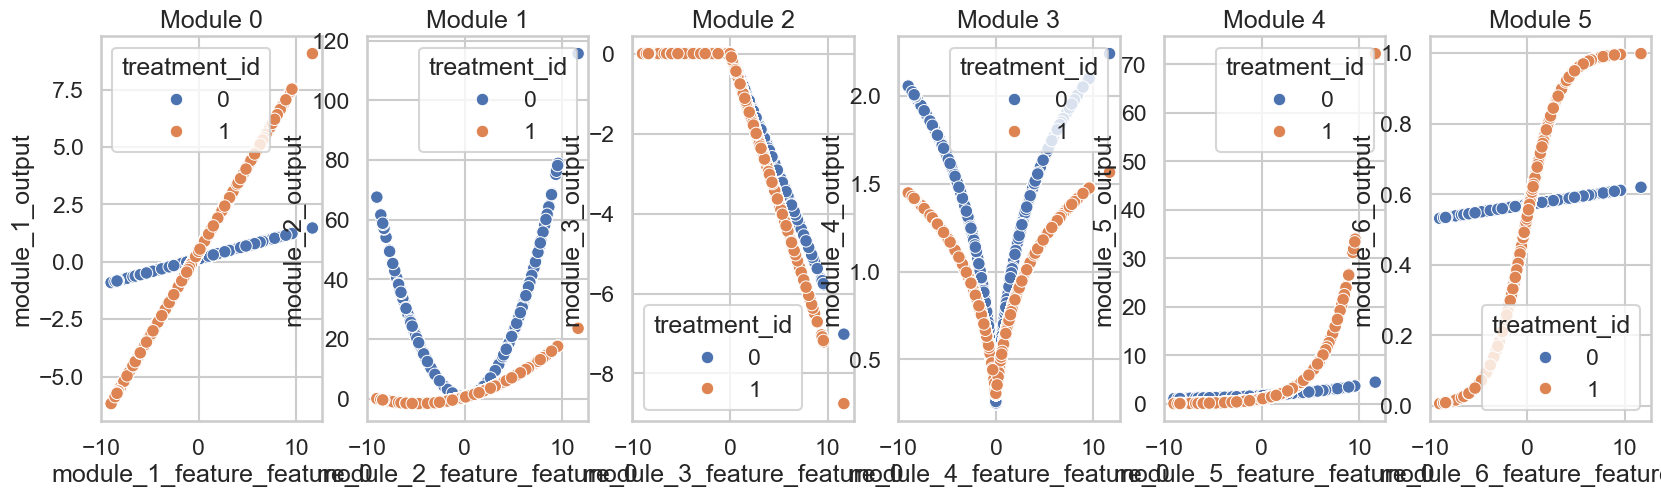

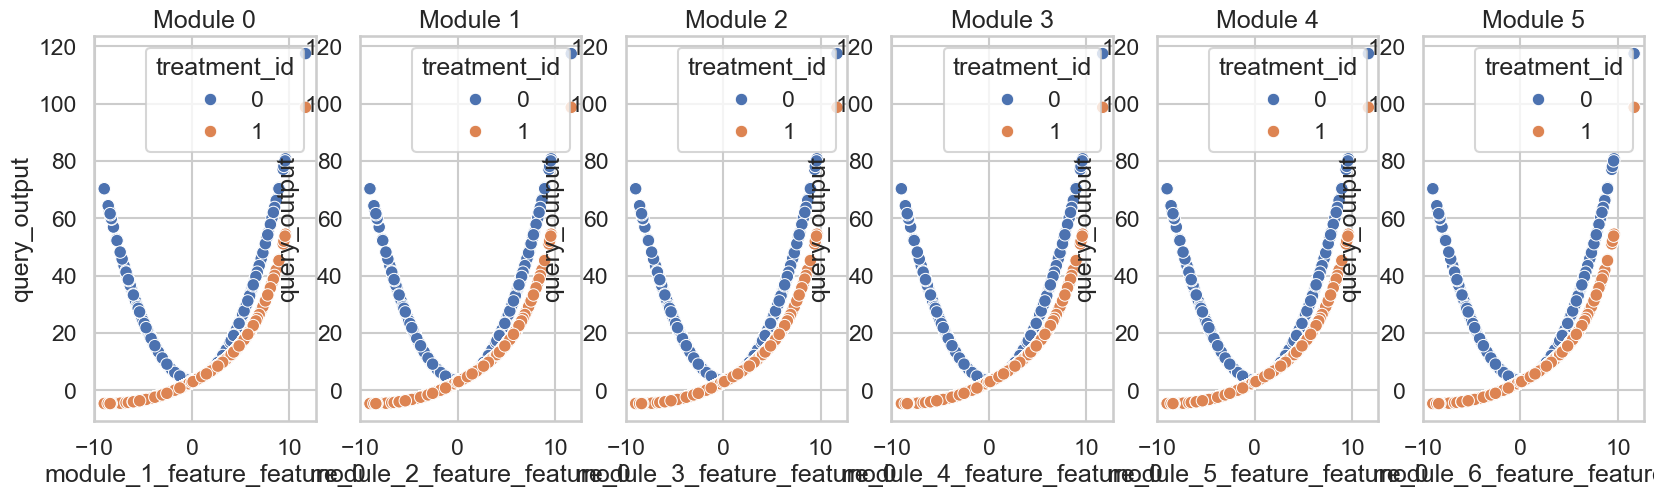

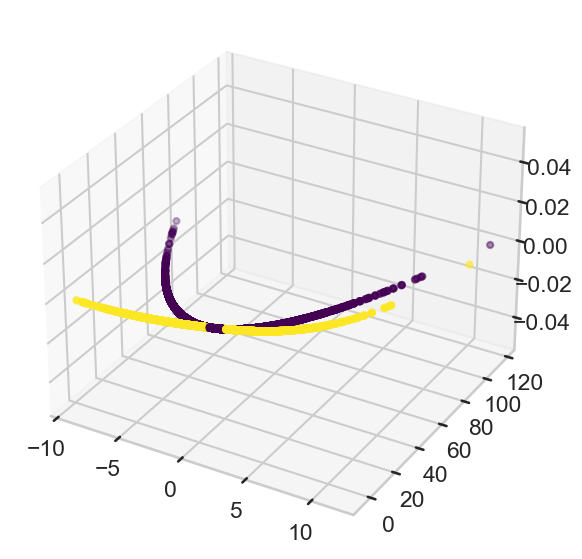

In [14]:
# Hypotheses to test
# 1. Each component output is a quadratic function of the input features.
# 2. Plot final output vs input features.

# Hypothesis 1
# plot 1
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("talk")
max_modules = 6
fig, ax = plt.subplots(1, max_modules, figsize=(20, 5))
for i in range(max_modules):
    sns.scatterplot(x=f"module_{i+1}_feature_feature_0", y=f"module_{i+1}_output", data=data, ax=ax[i],hue="treatment_id")
    ax[i].set_title(f"Module {i}")

fig, ax = plt.subplots(1, max_modules, figsize=(20, 5))
for i in range(max_modules):
    sns.scatterplot(x=f"module_{i+1}_feature_feature_0", y=f"query_output", data=data, ax=ax[i],hue="treatment_id")
    ax[i].set_title(f"Module {i}")

# Have a 3D plot for two features and one output
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data["module_1_feature_feature_0"], data["query_output"], c=data["treatment_id"], cmap='viridis')



In [8]:
train_df

,query_id,treatment_id,tree_depth,feature_0,query_output
0,0.0,1.0,6.0,2.332094,7.601424
1,1.0,0.0,6.0,1.837576,6.601998
2,2.0,0.0,6.0,4.455093,20.304125
3,3.0,1.0,6.0,2.381806,7.721851
4,4.0,0.0,6.0,0.282987,3.614654
...,...,...,...,...,...
9994,9994.0,1.0,6.0,-1.242620,0.796382
9995,9995.0,0.0,6.0,1.952960,6.971097
9996,9996.0,1.0,6.0,2.662555,8.422631
9998,9998.0,1.0,6.0,-2.571321,-1.061101


In [7]:
data

,query_id,treatment_id,tree_depth,num_module_1,num_module_2,num_module_3,num_module_4,num_module_5,num_module_6,module_1_feature_feature_0,...,module_4_feature_feature_0,module_5_feature_feature_0,module_6_feature_feature_0,module_1_output,module_2_output,module_3_output,module_4_output,module_5_output,module_6_output,query_output
0,0,0,6,1,1,1,1,1,1,2.332094,...,2.332094,2.332094,2.332094,0.401709,5.529461,-1.402090,1.192465,2.031730,0.580701,8.333976
1,1,0,6,1,1,1,1,1,1,1.837576,...,1.837576,1.837576,1.837576,0.344813,3.756212,-1.104778,1.066541,1.960617,0.578593,6.601998
2,2,0,6,1,1,1,1,1,1,4.455093,...,4.455093,4.455093,4.455093,0.645970,17.781338,-2.678468,1.578854,2.386717,0.589714,20.304125
3,3,0,6,1,1,1,1,1,1,2.381806,...,2.381806,2.381806,2.381806,0.407429,5.730305,-1.431977,1.204072,2.039102,0.580912,8.529843
4,4,0,6,1,1,1,1,1,1,0.282987,...,0.282987,0.282987,0.282987,0.165950,0.841152,-0.170136,0.444367,1.761372,0.571950,3.614654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,9995,1,6,1,1,1,1,1,1,1.952960,...,1.952960,1.952960,1.952960,1.908896,2.572729,-1.464571,0.839177,2.077353,0.782793,6.716378
19996,9996,1,6,1,1,1,1,1,1,2.662555,...,2.662555,2.662555,2.662555,2.432404,3.510655,-1.996713,0.946447,2.685572,0.844267,8.422631
19997,9997,1,6,1,1,1,1,1,1,1.011480,...,1.011480,1.011480,1.011480,1.214315,1.473405,-0.758533,0.647935,1.479877,0.677058,4.734057
19998,9998,1,6,1,1,1,1,1,1,-2.571321,...,-2.571321,-2.571321,-2.571321,-1.428915,-1.197004,0.000000,0.933882,0.420331,0.210605,-1.061101


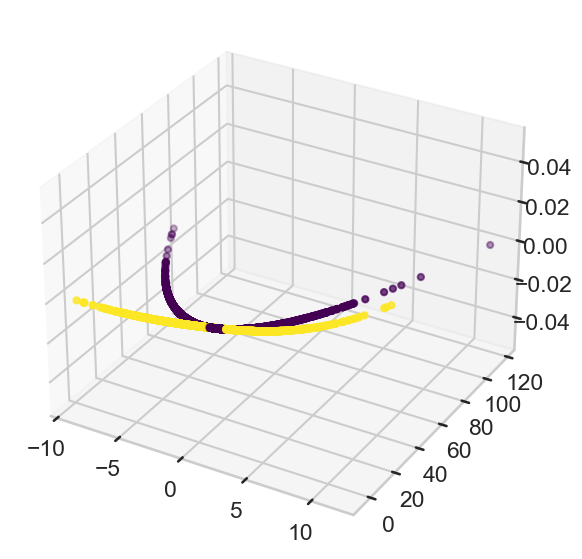

In [13]:
# Hypotheses to test
# 1. Each component output is a quadratic function of the input features.
# 2. Plot final output vs input features.

# Hypothesis 1
# plot 1
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("talk")
max_modules = 6
# fig, ax = plt.subplots(1, max_modules, figsize=(20, 5))

# Have a 3D plot for two features and one output
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train_df["feature_0"],train_df["query_output"], c=train_df["treatment_id"], cmap='viridis')



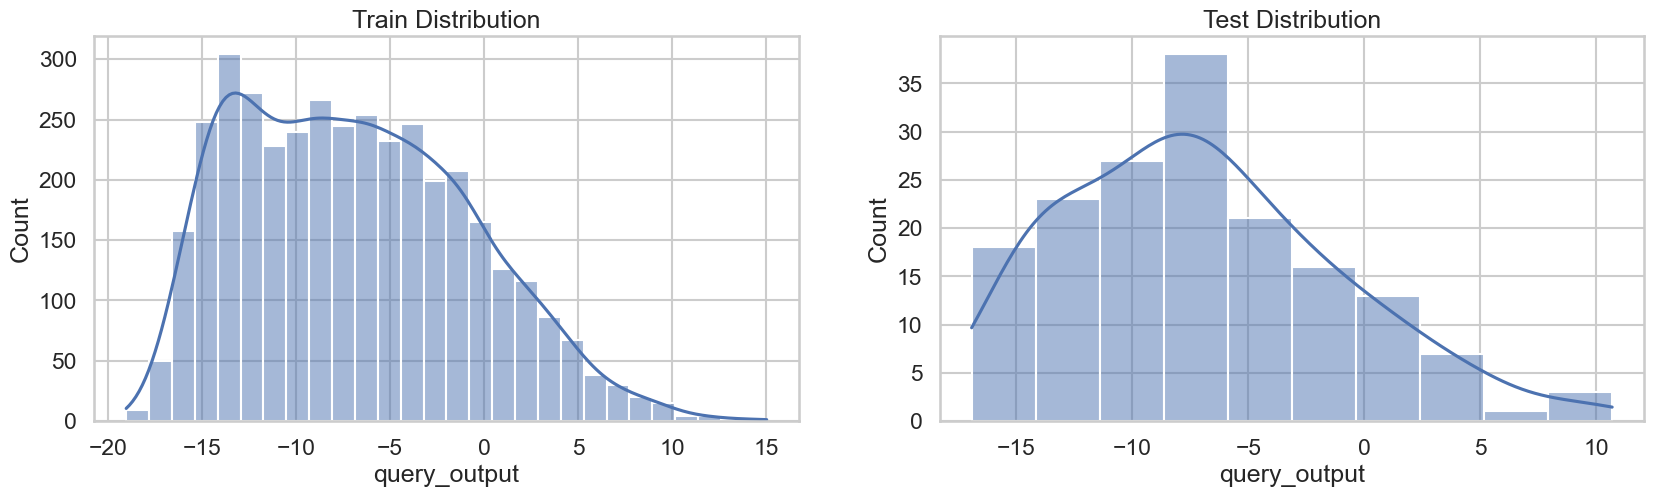

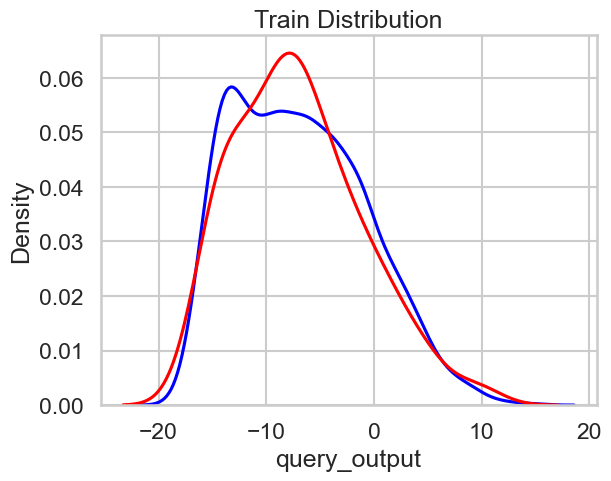

In [34]:
# plot distribution of the output for train and test df in the same plot
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.histplot(train_df["query_output"], ax=ax[0], kde=True)
ax[0].set_title("Train Distribution")
sns.histplot(test_df["query_output"], ax=ax[1], kde=True)
ax[1].set_title("Test Distribution")
plt.show()

# plot distribution of the output for train and test df in the same plot
# scale the distribution by dividing by the number of samples
sns.kdeplot(train_df["query_output"], label="Train", color="blue")
sns.kdeplot(test_df["query_output"], label="Test", color="red")
plt.title("Train Distribution")
plt.show()





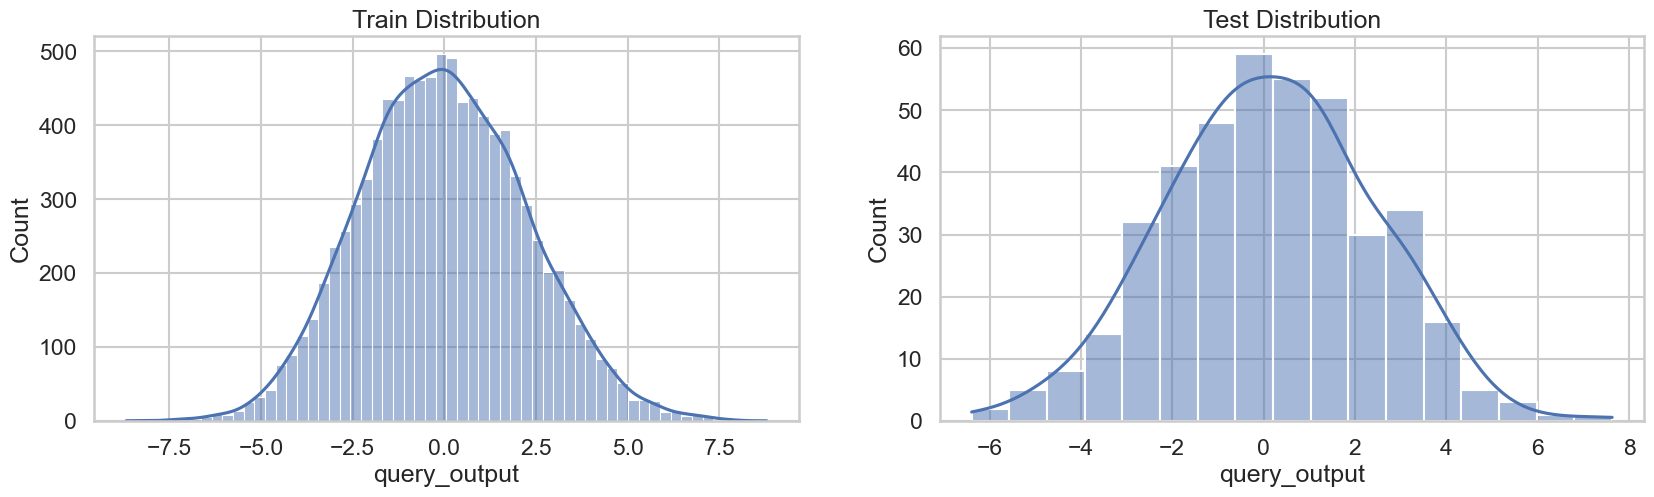

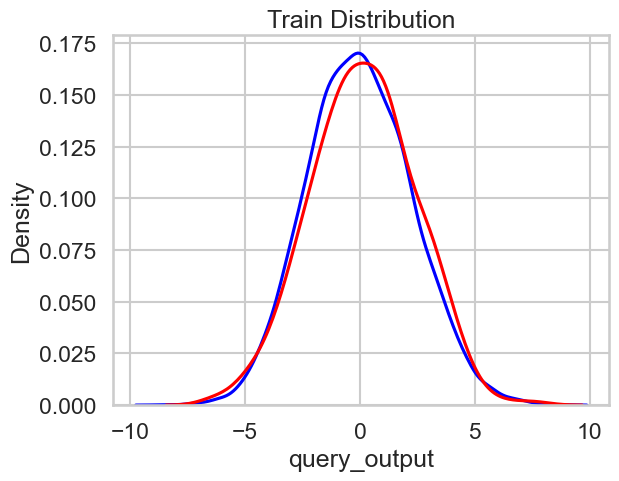

In [22]:
# plot distribution of the output for train and test df in the same plot
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.histplot(train_df["query_output"], ax=ax[0], kde=True)
ax[0].set_title("Train Distribution")
sns.histplot(test_df["query_output"], ax=ax[1], kde=True)
ax[1].set_title("Test Distribution")
plt.show()

# plot distribution of the output for train and test df in the same plot
# scale the distribution by dividing by the number of samples
sns.kdeplot(train_df["query_output"], label="Train", color="blue")
sns.kdeplot(test_df["query_output"], label="Test", color="red")
plt.title("Train Distribution")
plt.show()





In [4]:
train_df

,query_id,treatment_id,tree_depth,feature_0,query_output,estimated_effect
0,0.0,1.0,6.0,2.332094,7.601424,-0.822095
1,1.0,0.0,6.0,1.837576,6.601998,-0.255748
2,2.0,0.0,6.0,4.455093,20.304125,-6.821352
3,3.0,1.0,6.0,2.381806,7.721851,-0.888784
4,4.0,0.0,6.0,0.282987,3.614654,-0.285166
...,...,...,...,...,...,...
9994,9994.0,1.0,6.0,-1.242620,0.796382,-4.102654
9995,9995.0,0.0,6.0,1.952960,6.971097,-0.372728
9996,9996.0,1.0,6.0,2.662555,8.422631,-1.466716
9998,9998.0,1.0,6.0,-2.571321,-1.061101,-10.133957


In [5]:
test_df

,query_id,treatment_id,tree_depth,feature_0,query_output,estimated_effect
13,13.0,1.0,6.0,-1.950719,-0.242397,-7.048714
21,21.0,0.0,6.0,1.725250,6.262990,-0.150230
39,39.0,0.0,6.0,1.461894,5.546099,0.051443
45,45.0,0.0,6.0,2.044264,7.278221,-0.471660
71,71.0,0.0,6.0,2.403060,8.614803,-0.920901
...,...,...,...,...,...,...
9894,9894.0,1.0,6.0,1.428701,5.579292,0.060589
9901,9901.0,1.0,6.0,-0.199435,2.485306,-0.977410
9922,9922.0,0.0,6.0,2.375805,8.505987,-0.880636
9980,9980.0,1.0,6.0,-1.763250,0.022115,-6.207575


# Data baseline model 

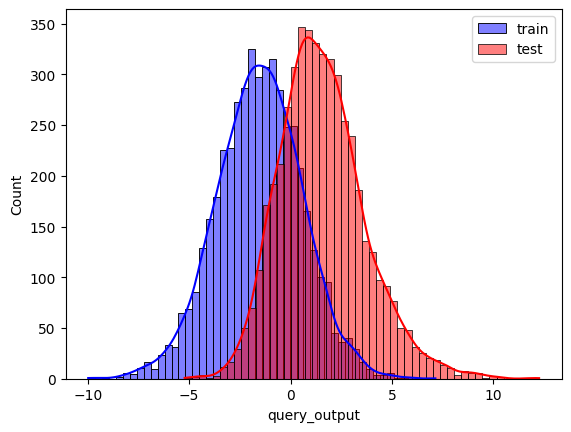

In [5]:
# plot feature distribution of module_1_feature_feature_0
import seaborn as sns
# sns.histplot(train_df[high_level_output], bins=50, color="blue", label="train", kde=True)
# sns.histplot(test_df[high_level_output], bins=50, color="red", label="test", kde=True)

# have two histograms based on treatment
sns.histplot(train_df[train_df["treatment_id"]==0]["query_output"], bins=50, color="blue", label="train", kde=True)
sns.histplot(train_df[train_df["treatment_id"]==1]["query_output"], bins=50, color="red", label="test", kde=True)

plt.legend()




# sns.histplot(data[high_level_output], bins=50, color="green")

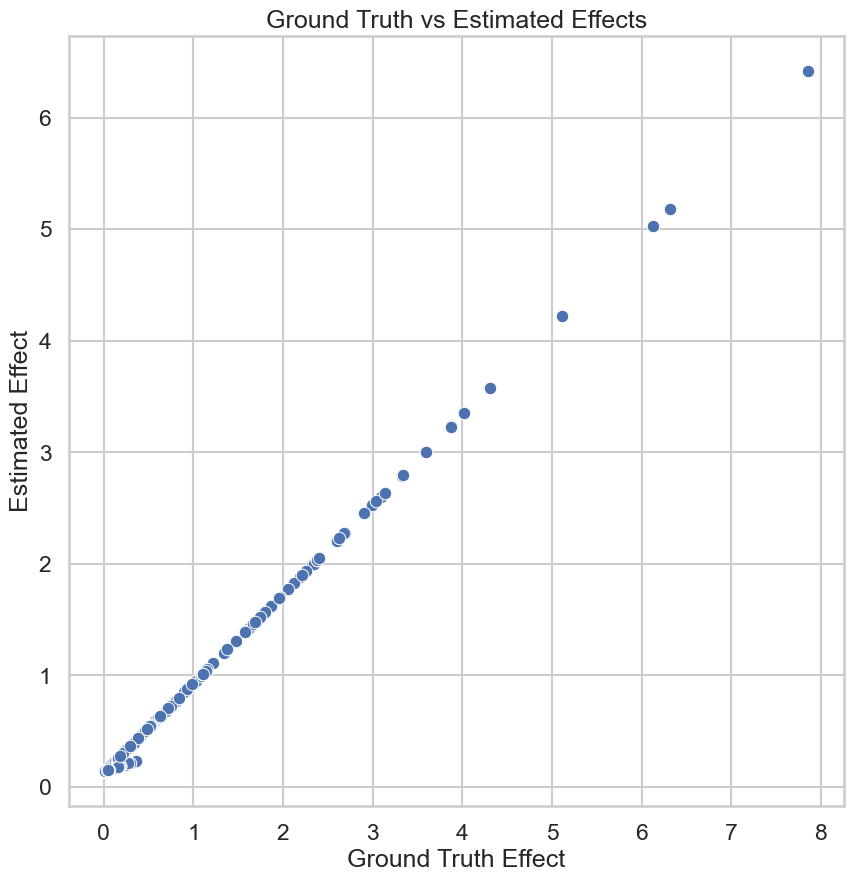

In [55]:
# scatter plot of ground truth vs estimated effects
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(x="ground_truth_effect", y="estimated_effect", data=baseline_combined_df, ax=ax)
ax.set_xlabel("Ground Truth Effect")
ax.set_ylabel("Estimated Effect")
ax.set_title("Ground Truth vs Estimated Effects")

plt.show()

